In [1]:
import torch
import sys

import matplotlib.pyplot as plt
import numpy as np

sys.path.append("../")

import tools.plot

import json

from ThinLens.Models import F0D0Model6, F0D0Model_single, F0D0Model12, SIS18_Lattice_minimal_sa
import ThinLens.Elements as Elements

from matplotlib.backends.backend_pdf import PdfPages


In [2]:
# visualize difference in multipole components


def plot_multipole(initialDiffNormal, finalDiffNormal=None):
    multipoleFig, multipoleAxes = plt.subplots(2, 2, sharex=True, figsize=(12,8))
    multipoleFig.suptitle("multipole strengths")


    for i in range(len(multipoleAxes)):
        for j in range(len(multipoleAxes[i])):
            multipoleAxes[i, j].ticklabel_format(style="sci", scilimits=(0,0))

    multipoleAxes[0, 0].plot(model.positions, abs(initialDiffNormal[0]), 'o-')
    multipoleAxes[0, 1].plot(model.positions, initialDiffNormal[1], 'o-')
    
    bottom_1, top_1 = multipoleAxes[0, 0].get_ylim()
    bottom_2, top_2 = multipoleAxes[0, 1].get_ylim()
    
    if not (finalDiffNormal is None):
        multipoleAxes[1, 0].plot(model.positions, abs(finalDiffNormal[0]), 'o-')
        multipoleAxes[1, 1].plot(model.positions, finalDiffNormal[1], 'o-')
        
        #multipoleAxes[1, 0].set_ylim(bottom_1, top_1)
        #multipoleAxes[1, 1].set_ylim(bottom_2, top_2)

    multipoleAxes[0, 0].set_title("k1n")
    multipoleAxes[0, 1].set_title("k2n")
    multipoleAxes[0, 0].set_ylabel("initial")
    multipoleAxes[1, 0].set_ylabel("after training")

    multipoleAxes[1, 0].set_xlabel("pos / m")
    multipoleAxes[1, 1].set_xlabel("pos / m")
    
    #multipoleAxes[0, 0].set_yscale('log')
    #multipoleAxes[1, 0].set_yscale('log')
    #multipoleAxes[0, 1].set_yscale('log')
    #multipoleAxes[1, 1].set_yscale('log')
    
    return multipoleFig
    
def plot_trajectories(initialTrajectoriesDifference, finalTrajectoriesDifference=None):
    # plot initial trajectories
    figTrajectories, axesTrajectories = plt.subplots(2, 2, sharex=True, figsize=(12,8))
    figTrajectories.suptitle("trajectories")

    for i in range(len(axesTrajectories)):
        for j in range(len(axesTrajectories[i])):
            axesTrajectories[i, j].ticklabel_format(style="sci", scilimits=(0,0))

    #initialTrajectoriesDifference = tools.plot.track(model, bunch, 1) - tools.plot.track(perturbedModel, bunch, 1)

    tools.plot.trajectories(axesTrajectories[0, 0], initialTrajectoriesDifference, model, plane="x")
    tools.plot.trajectories(axesTrajectories[0, 1], initialTrajectoriesDifference, model, plane="y")
    
    bottom_x, top_x = axesTrajectories[0, 0].get_ylim()
    bottom_y, top_y = axesTrajectories[0, 1].get_ylim()
        
    
    if not (finalTrajectoriesDifference is None):
        tools.plot.trajectories(axesTrajectories[1, 0], finalTrajectoriesDifference, model, plane="x")
        tools.plot.trajectories(axesTrajectories[1, 1], finalTrajectoriesDifference, model, plane="x")
        
        #axesTrajectories[1, 0].set_ylim(bottom_x, top_x)
        #axesTrajectories[1, 1].set_ylim(bottom_y, top_y)


    axesTrajectories[0, 0].set_ylabel("initial diff.")
    axesTrajectories[1, 0].set_ylabel("after training")
    axesTrajectories[1, 0].set_xlabel("hor. pos / m")
    axesTrajectories[1, 1].set_xlabel("ver. pos / m")
    
    return figTrajectories

    
def plot_beta(modelTwiss, perturbedTwiss, finalModelTwiss=None):

    # plot inital beta
    
    #finalModelTwiss = model.getTwiss()


    figBeta, axesBeta = plt.subplots(2, sharex=True)
    figBeta.suptitle("beta-function")
    try:
        axesBeta[0].plot(modelTwiss["s"], modelTwiss["betx"] - perturbedTwiss["betx"], label="hor.")
        axesBeta[0].plot(modelTwiss["s"], modelTwiss["bety"] - perturbedTwiss["bety"], label="ver.")
        bottom, top = axesBeta[0].get_ylim()

        if not (finalModelTwiss is None):
            axesBeta[1].plot(modelTwiss["s"], finalModelTwiss["betx"] - perturbedTwiss["betx"], label="hor.")
            axesBeta[1].plot(modelTwiss["s"], finalModelTwiss["bety"] - perturbedTwiss["bety"], label="ver.")
            #axesBeta[1].set_ylim(bottom, top)

    except ThinLens.Models.TwissFailed as e:
        print(e)
        print("warning twiss failed")

    axesBeta[0].set_ylabel("initial diff. / m")
    axesBeta[1].set_ylabel("final diff. / m")
    
    axesBeta[0].legend()
    #axesBeta[1].legend()
    
    return figBeta


def plot_Twiss_perturbedModel(modelTwiss, perturbedTwiss):
    figBeta2, axesBeta2 = plt.subplots(2, sharex=True)
    figBeta2.suptitle("beta-function")
    try:
        axesBeta2[0].plot(modelTwiss["s"], perturbedTwiss["betx"], label="hor.")
        axesBeta2[1].plot(modelTwiss["s"], perturbedTwiss["bety"], label="ver.")
        axesBeta2[0].plot(modelTwiss["s"], modelTwiss["betx"], label="hor.")
        axesBeta2[1].plot(modelTwiss["s"], modelTwiss["bety"], label="ver.")
    except ThinLens.Models.TwissFailed as e:
        print(e)
        print("warning twiss failed")
    axesBeta2[0].set_ylabel("betx / m")
    axesBeta2[1].set_ylabel("bety / m")

In [3]:
# set up models
Lattice = F0D0Model12


dim = 6
slices = 4
quadSliceMultiplicity = 1
dtype = torch.double
device = torch.device("cpu")
outputPerElement = True  # exceeds outputAtBPM
outputAtBPM = True

model = Lattice(dim=dim, slices=slices, quadSliceMultiplicity=quadSliceMultiplicity,
                dtype=dtype,).to(device)

perturbedModel = Lattice(dim=dim, slices=slices, quadSliceMultiplicity=quadSliceMultiplicity,
                         dtype=dtype).to(device)

In [11]:
filename = '/Users/sappel/gsi_d/machine_learning/thin_lens_sa/test/FODO_sa/test.pt'
filename_pdf = 'test.pdf'
basicList = torch.load(filename) 

initialTrajectoriesDifference, finalTrajectoriesDifference, initialDiffNormal, initialDiffSkew, modelTwiss, perturbedTwiss, finalModelTwiss, finalDiffNormal, finalDiffSkew, k_poch,loss_count, tune_x, tune_y, tune1, tune2, lattice_model, lattice_perturbedModel, time = basicList 

perturbedModel_s, perturbedModel_bx, perturbedModel_by = lattice_perturbedModel

model_s, model_bx, model_by = lattice_model



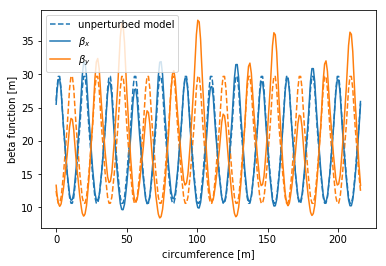

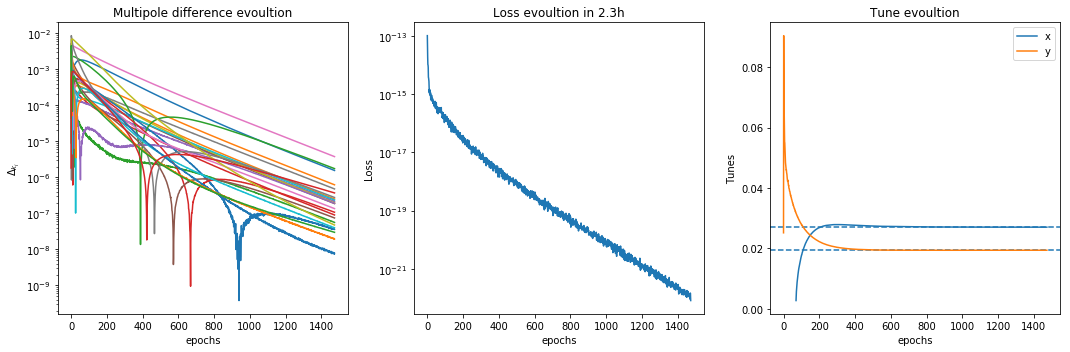

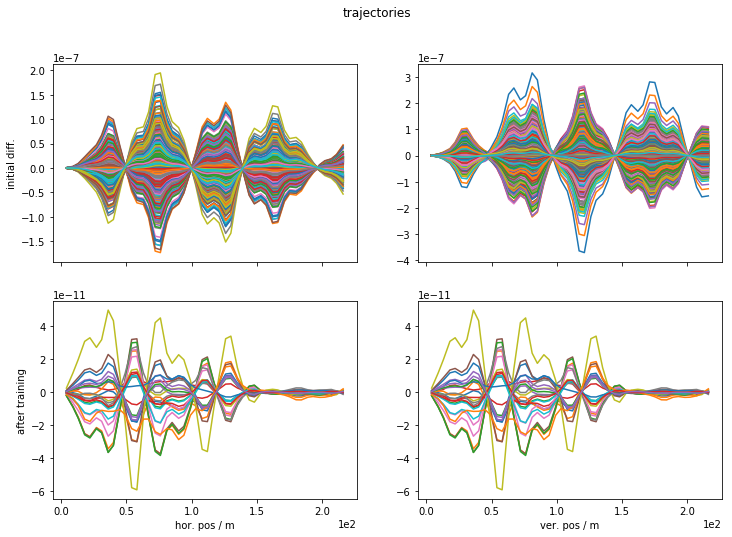

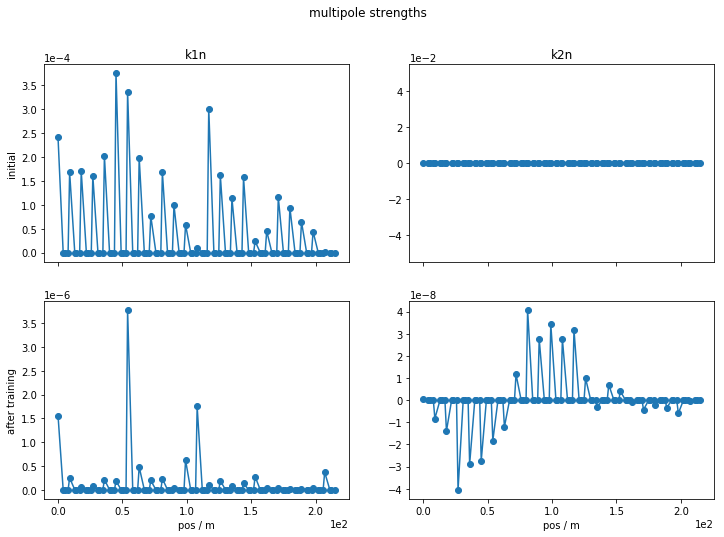

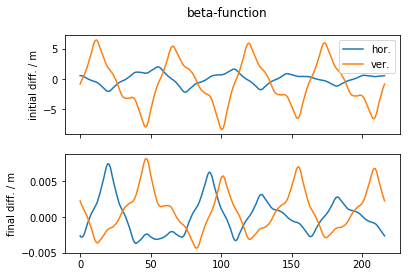

In [12]:
pp = PdfPages(filename_pdf)

figBeta2 = plt.figure()

plt.plot(model_s, model_bx, '--', color='#1f77b4', label='unperturbed model')
plt.plot(model_s, model_by, '--', color='#ff7f0e')

plt.plot(perturbedModel_s, perturbedModel_bx, color='#1f77b4', label=r'$\beta_x$')
plt.plot(perturbedModel_s, perturbedModel_by, color='#ff7f0e', label=r'$\beta_y$')

plt.xlabel('circumference [m]')
plt.ylabel('beta function [m]')
plt.legend()

pp.savefig(figBeta2)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

i = 0
for temp in zip(*k_poch):
    ax1.plot(abs(np.array(temp)), label=str(i))
    i = i + 1
#plt.ticklabel_format(axis="y", style="sci", scilimits=(1,1))
#ax1.set_xlim(-10,20)

ax2.plot(loss_count)


ax3.axhline(tune1, ls='--')
ax3.axhline(tune2, ls= '--')

ax3.plot(tune_x, label='x')
ax3.plot(tune_y, label='y')

ax1.set_title('Multipole difference evoultion')
ax2.set_title('Loss evoultion in ' + str(np.round(time/3600,1)) + 'h')
ax3.set_title('Tune evoultion')



ax1.set_yscale('log')
ax2.set_yscale('log')

#ax1.legend()#loc='lower right')
ax3.legend()#loc='lower right')

ax1.set_xlabel('epochs')
ax2.set_xlabel('epochs')
ax3.set_xlabel('epochs')

ax1.set_ylabel(r'$\Delta_{k_i}$')
ax2.set_ylabel(r'Loss')
ax3.set_ylabel(r'Tunes')

fig.tight_layout()


figTrajectories = plot_trajectories(initialTrajectoriesDifference, finalTrajectoriesDifference)

multipoleFig = plot_multipole(initialDiffNormal, finalDiffNormal)

figBeta = plot_beta(modelTwiss, perturbedTwiss, finalModelTwiss)


pp.savefig(fig)
pp.savefig(figTrajectories)    
pp.savefig(multipoleFig)
pp.savefig(figBeta)


pp.close()